# Data Analytics Competition Find IT UGM - Kyozo Hotel Price

## Tim Oh Data Euy : 
- Gerend Christopher 
- Felix Fernando 
- Jeremy

## Permasalahan : 
Kyozo, salah satu jaringan hotel dunia, membutuhkan bantuan konsultan data untuk membuat model prediksi harga untuk pengembangan hotel-hotel baru mereka. Sebagai konsultan data, Anda diberikan dataset dari ribuan hotel yang mereka miliki saat ini.

Namun, Kyozo bukanlah tim yang ahli dalam hal data. Anda diberikan dataset apa adanya dan Anda harus mencocokkan kolom dan nilai yang diberikan ke beberapa contoh hotel untuk diprediksi.

## Goal:
Membuat model prediksi harga pengembangan hotel-hotel baru dengan performa yang baik (diukur dengan metrik Mean Absolute Error)


# Importing Library

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import display

# Model Library
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
import optuna

from catboost import CatBoostClassifier, Pool, cv

import lightgbm as lgb

import xgboost as xgb

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from category_encoders import OrdinalEncoder as oe

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# custom plot seaborn
plt.rcParams["figure.figsize"] = (8,6)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette='tab10')

np.random.seed(10)
%matplotlib inline

# Data Preparation

### Features

`facilities` - fasilitas yang disediakan

`rating` - rating yang diberikan pengunjung

`location` - lokasi kota tempat hotel berada 

### Target variables :
`price` - harga pengembangan hotel

### Load Data

In [139]:
df_features = pd.read_csv('data/train_features.csv') # Membaca  feature data train
df_labels = pd.read_csv('data/train_label.csv') # Membaca label data train 
df_test_features = pd.read_csv('data/test_feature.csv') # membaca feature data test

In [140]:
display(df_labels.columns) # Mengambil data kolom dari df_labels
display(df_features.columns) # Mengambil data kolom dari df_features
display(df_test_features.columns) # Mengambil data kolom dari df_test_features

Index(['Price'], dtype='object')

Index(['facilities', 'rating', 'location'], dtype='object')

Index(['ID', 'facilities', 'rating', 'location'], dtype='object')

In [141]:
df_features.head()

,facilities,rating,location
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol


In [142]:
df_test_features.head()

,ID,facilities,rating,location
0,0,GymrestaurantbarInternetSwimmingPools,8.0 ExcellentFrom 1 reviews,Stokol
1,1,Poolrestaurantgyminternetbar,7.4 Very GoodFrom 22 reviews,Hallerson
2,2,BARSwimmingPoolsInternetgym,0.0 FairFrom 4 reviews,Hallerson
3,3,gymSwimmingPoolsBARintrnetRestaurant,6.8 Very GoodFrom 13 reviews,Andeman
4,4,gymRestaurantpoolbarintrnet,0.0 FairFrom 9 reviews,Hallerson


### Data Cleansing

In [143]:
print('Features Dataset')
display(df_features.info())

print('Labels Dataset')
display(df_labels.info())

print('Test Features Dataset')
df_test_features.info()

Features Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   facilities  2765 non-null   object
 1   rating      2429 non-null   object
 2   location    3066 non-null   object
dtypes: object(3)
memory usage: 72.0+ KB


None

Labels Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   3066 non-null   object
dtypes: object(1)
memory usage: 24.1+ KB


None

Test Features Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          767 non-null    int64 
 1   facilities  767 non-null    object
 2   rating      767 non-null    object
 3   location    767 non-null    object
dtypes: int64(1), object(3)
memory usage: 24.1+ KB


In [144]:
df_features.isna().sum() # Memeriksa kolom dengan data null pada df_features

facilities    301
rating        637
location        0
dtype: int64

In [145]:
df_labels.isna().sum() # Memeriksa kolom dengan data null pada df_labels

Price    0
dtype: int64

In [146]:
df_test_features.isna().sum() # Memeriksa kolom dengan data null pada df_test_features

ID            0
facilities    0
rating        0
location      0
dtype: int64

In [147]:
df_features

,facilities,rating,location
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol
...,...,...,...
3061,barInternet,NaN,Andeman
3062,restaurantBarInternet,8.1 ExcellentFrom 4 reviews,Uberlandia
3063,Barrestaurantswimmingpools,6.7 Very GoodFrom 10 reviews,Willsmian
3064,Restaurant,NaN,Hallerson


In [148]:
df_train = df_features.join(df_labels)
df_train

,facilities,rating,location,Price
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol,"13,500avg/night"
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,"13,000avg/night"
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland,"19,000avg/night"
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,"6,000avg/night"
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol,"20,000avg/night"
...,...,...,...,...
3061,barInternet,NaN,Andeman,"31,625avg/night"
3062,restaurantBarInternet,8.1 ExcellentFrom 4 reviews,Uberlandia,"30,500avg/night"
3063,Barrestaurantswimmingpools,6.7 Very GoodFrom 10 reviews,Willsmian,"14,000avg/night"
3064,Restaurant,NaN,Hallerson,"8,500avg/night"


In [149]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   facilities  2765 non-null   object
 1   rating      2429 non-null   object
 2   location    3066 non-null   object
 3   Price       3066 non-null   object
dtypes: object(4)
memory usage: 95.9+ KB


### Handling Null

READ THIS: kalo dua duanya null hmm, drop aja la ya (ger)

In [150]:
# check both facilities and rating null values

df_train[df_train['facilities'].isnull() & df_train['rating'].isnull()]

,facilities,rating,location,Price
16,NaN,NaN,Machlessvile,"3,200avg/night"
44,NaN,NaN,Uberlandia,"17,000avg/night"
58,NaN,NaN,Stokol,"1,800avg/night"
73,NaN,NaN,Stokol,"23,050avg/night"
79,NaN,NaN,Stokol,"1,800avg/night"
...,...,...,...,...
2998,NaN,NaN,Machlessvile,"3,500avg/night"
3015,NaN,NaN,Stokol,"8,000avg/night"
3021,NaN,NaN,Uberlandia,"8,000avg/night"
3030,NaN,NaN,Willsmian,"3,700avg/night"


In [151]:
# drop if facilities and rating both null

df_train = df_train.dropna(subset=['facilities', 'rating'], how='all').reset_index(drop=True)
df_train

,facilities,rating,location,Price
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol,"13,500avg/night"
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,"13,000avg/night"
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland,"19,000avg/night"
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,"6,000avg/night"
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol,"20,000avg/night"
...,...,...,...,...
2862,barInternet,NaN,Andeman,"31,625avg/night"
2863,restaurantBarInternet,8.1 ExcellentFrom 4 reviews,Uberlandia,"30,500avg/night"
2864,Barrestaurantswimmingpools,6.7 Very GoodFrom 10 reviews,Willsmian,"14,000avg/night"
2865,Restaurant,NaN,Hallerson,"8,500avg/night"


READ THIS: susah kalo fasilitias nya engga ada untuk fill nan nya. jadi mnrt ger di drop ae

In [152]:
# drop null values in facilities

df_train[df_train['facilities'].isnull()]

,facilities,rating,location,Price
28,NaN,6.0 Very GoodFrom 43 reviews,Wanderland,"15,000avg/night"
57,NaN,10.0 ExcellentFrom 1 review,Wanderland,"20,000avg/night"
102,NaN,6.4 Very GoodFrom 1 review,Andeman,"10,000avg/night"
133,NaN,6.0 Very GoodFrom 43 reviews,Andeman,"15,000avg/night"
145,NaN,6.0 Very GoodFrom 43 reviews,Hallerson,"15,000avg/night"
...,...,...,...,...
2706,NaN,6.4 Very GoodFrom 1 review,Stokol,"10,000avg/night"
2728,NaN,7.6 Very GoodFrom 1 review,Stokol,"11,000avg/night"
2746,NaN,8.3 ExcellentFrom 4 reviews,Ubisville,"35,000avg/night"
2767,NaN,6.0 Very GoodFrom 43 reviews,Wanderland,"15,000avg/night"


In [153]:
# drop null values in facilities

df_train = df_train.dropna(subset=['facilities']).reset_index(drop=True)
df_train

,facilities,rating,location,Price
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol,"13,500avg/night"
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,"13,000avg/night"
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland,"19,000avg/night"
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,"6,000avg/night"
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol,"20,000avg/night"
...,...,...,...,...
2760,barInternet,NaN,Andeman,"31,625avg/night"
2761,restaurantBarInternet,8.1 ExcellentFrom 4 reviews,Uberlandia,"30,500avg/night"
2762,Barrestaurantswimmingpools,6.7 Very GoodFrom 10 reviews,Willsmian,"14,000avg/night"
2763,Restaurant,NaN,Hallerson,"8,500avg/night"


READ THIS: nah gimn skrang ttg rating. bisa jadi drop?, bisa jadi isi tapi cuma angka rating paling atau tipe(kek excellent dll), tapi ga bisa yang byk review nya

In [154]:
# drop null values rating

df_train = df_train.dropna(subset=['rating']).reset_index(drop=True)
df_train

,facilities,rating,location,Price
0,RestaurantBARSwimmingPools,7.8 Very GoodFrom 10 reviews,Stokol,"13,500avg/night"
1,intrnetRestaurantgym,5.6 GoodFrom 4 reviews,Machlessvile,"13,000avg/night"
2,restaurantgympoolBar,7.2 Very GoodFrom 38 reviews,Wanderland,"19,000avg/night"
3,BARRestaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,"6,000avg/night"
4,InternetRestaurant,7.2 Very GoodFrom 30 reviews,Stokol,"20,000avg/night"
...,...,...,...,...
2322,restaurantBAR,7.6 Very GoodFrom 3 reviews,Andeman,"5,000avg/night"
2323,barrestaurantPoolGym,7.8 Very GoodFrom 351 reviews,Andeman,"30,000avg/night"
2324,restaurantBarInternet,8.1 ExcellentFrom 4 reviews,Uberlandia,"30,500avg/night"
2325,Barrestaurantswimmingpools,6.7 Very GoodFrom 10 reviews,Willsmian,"14,000avg/night"


### Feature Engineering

READ THIS: split rating angka, tipe(kek excellent, good, blabla), dan berapa review nya, hapus avg/night di price, split facilites (hati-hati masalah case sensitive), trus ger pikir bgusnya kita encoding ada apa aja fasilitas nya 

In [155]:
# function to split facilities string by keywords and encoding it

def transform_strings_facilities(df, keywords):
    """
    Lowercase and split string values in a Pandas Series based on specified keywords.
    
    Args:
        data (pd.Series): The input Pandas Series.
        keywords (list): The list of keywords to split the string values.
    
    Returns:
        pd.Series: The transformed Pandas Series.
    """
    data = df['facilities']
    data = data.str.lower()  # Convert values to lowercase
    
    # Replace keywords with a space before and after
    for keyword in keywords:
        data = data.str.replace(keyword.lower(), f' {keyword.lower()} ', regex=False)
    
    # Replace 'swimmingpools' with 'pool'
    data = data.str.replace('swimming', '', regex=False)
    data = data.str.replace('s', '', regex=False)
    
    # Replace 'intrnet' with 'internet'
    data = data.str.replace('intrnet', 'internet', regex=False)
    
    # Replace 'retaurant' with 'restaurant'
    data = data.str.replace('retaurant', 'restaurant', regex=False)
    
    for keyword in keywords:
        df[keyword] = data.str.contains(keyword, regex=False).astype(int)
        
    # Split values by space
    data = data.str.split()
    
    # Join the lists of substrings into a single string
    data = data.str.join(' ')
    
    df['facilities'] = data
    
    return df

In [156]:
keywords = ['restaurant', 'bar', 'pool', 'internet', 'gym']
df_train = transform_strings_facilities(df_train, keywords)

df_train

,facilities,rating,location,Price,restaurant,bar,pool,internet,gym
0,restaurant bar pool,7.8 Very GoodFrom 10 reviews,Stokol,"13,500avg/night",1,1,1,0,0
1,internet restaurant gym,5.6 GoodFrom 4 reviews,Machlessvile,"13,000avg/night",1,0,0,1,1
2,restaurant gym pool bar,7.2 Very GoodFrom 38 reviews,Wanderland,"19,000avg/night",1,1,1,0,1
3,bar restaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,"6,000avg/night",1,1,0,0,0
4,internet restaurant,7.2 Very GoodFrom 30 reviews,Stokol,"20,000avg/night",1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2322,restaurant bar,7.6 Very GoodFrom 3 reviews,Andeman,"5,000avg/night",1,1,0,0,0
2323,bar restaurant pool gym,7.8 Very GoodFrom 351 reviews,Andeman,"30,000avg/night",1,1,1,0,1
2324,restaurant bar internet,8.1 ExcellentFrom 4 reviews,Uberlandia,"30,500avg/night",1,1,0,1,0
2325,bar restaurant pool,6.7 Very GoodFrom 10 reviews,Willsmian,"14,000avg/night",1,1,1,0,0


In [157]:
df_test_features = transform_strings_facilities(df_test_features, keywords)
df_test_features

,ID,facilities,rating,location,restaurant,bar,pool,internet,gym
0,0,gym restaurant bar internet pool,8.0 ExcellentFrom 1 reviews,Stokol,1,1,1,1,1
1,1,pool restaurant gym internet bar,7.4 Very GoodFrom 22 reviews,Hallerson,1,1,1,1,1
2,2,bar pool internet gym,0.0 FairFrom 4 reviews,Hallerson,0,1,1,1,1
3,3,gym pool bar internet restaurant,6.8 Very GoodFrom 13 reviews,Andeman,1,1,1,1,1
4,4,gym restaurant pool bar internet,0.0 FairFrom 9 reviews,Hallerson,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
762,762,bar pool restaurant gym,8.1 ExcellentFrom 9 reviews,Andeman,1,1,1,0,1
763,763,internet gym pool restaurant bar,8.0 ExcellentFrom 4 reviews,Wanderland,1,1,1,1,1
764,764,restaurant gym internet bar pool,7.4 Very GoodFrom 19 reviews,Andeman,1,1,1,1,1
765,765,gym internet bar pool restaurant,9.0 ExcellentFrom 17 reviews,Hallerson,1,1,1,1,1


In [158]:
display(df_train.loc[df_train['restaurant'] == 0].loc[df_train['bar'] == 0].loc[df_train['pool'] == 0].loc[df_train['internet'] == 0].loc[df_train['gym'] == 0])
display(df_test_features.loc[df_test_features['restaurant'] == 0].loc[df_test_features['bar'] == 0].loc[df_test_features['pool'] == 0].loc[df_test_features['internet'] == 0].loc[df_test_features['gym'] == 0])

,facilities,rating,location,Price,restaurant,bar,pool,internet,gym


,ID,facilities,rating,location,restaurant,bar,pool,internet,gym


READ THIS: Splitting rating

In [159]:
# split rating by number, category, and how many reviews

def transform_rating(df):
    data = df['rating'].str.split('From ')
    
    rate = pd.Series([data[i][0] for i in range(len(data))])
    review = pd.Series([data[i][1] for i in range(len(data))])
    
    # check nan values in rate
    idx = []
    for i in range(len(data)):
        if len(rate[i]) == 0:
            idx.append(i)
    
    # drop null values
    df = df.drop(idx).reset_index(drop=True)
    rate = rate.drop(idx).reset_index(drop=True)
    review = review.drop(idx).reset_index(drop=True)
    
    review = review.str.rstrip(' reviews').astype('int64')
    
    rate_num = pd.Series([rate[i][:3] for i in range(len(rate))]).astype('float64')
    rate_cat = pd.Series([rate[i][4:] for i in range(len(rate))])
    rate_cat = rate_cat.str.replace(' Excellent', 'Excellent', regex=False)
    
    df['rate_num'] = rate_num
    df['rate_cat'] = rate_cat
    df['review_num'] = review
    
    return df
    

In [160]:
df_train = transform_rating(df_train)
display(df_train)
df_test_features = transform_rating(df_test_features)
display(df_test_features)

,facilities,rating,location,Price,restaurant,bar,pool,internet,gym,rate_num,rate_cat,review_num
0,restaurant bar pool,7.8 Very GoodFrom 10 reviews,Stokol,"13,500avg/night",1,1,1,0,0,7.8,Very Good,10
1,internet restaurant gym,5.6 GoodFrom 4 reviews,Machlessvile,"13,000avg/night",1,0,0,1,1,5.6,Good,4
2,restaurant gym pool bar,7.2 Very GoodFrom 38 reviews,Wanderland,"19,000avg/night",1,1,1,0,1,7.2,Very Good,38
3,bar restaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,"6,000avg/night",1,1,0,0,0,7.3,Very Good,6
4,internet restaurant,7.2 Very GoodFrom 30 reviews,Stokol,"20,000avg/night",1,0,0,1,0,7.2,Very Good,30
...,...,...,...,...,...,...,...,...,...,...,...,...
2299,restaurant bar,7.6 Very GoodFrom 3 reviews,Andeman,"5,000avg/night",1,1,0,0,0,7.6,Very Good,3
2300,bar restaurant pool gym,7.8 Very GoodFrom 351 reviews,Andeman,"30,000avg/night",1,1,1,0,1,7.8,Very Good,351
2301,restaurant bar internet,8.1 ExcellentFrom 4 reviews,Uberlandia,"30,500avg/night",1,1,0,1,0,8.1,Excellent,4
2302,bar restaurant pool,6.7 Very GoodFrom 10 reviews,Willsmian,"14,000avg/night",1,1,1,0,0,6.7,Very Good,10


,ID,facilities,rating,location,restaurant,bar,pool,internet,gym,rate_num,rate_cat,review_num
0,0,gym restaurant bar internet pool,8.0 ExcellentFrom 1 reviews,Stokol,1,1,1,1,1,8.0,Excellent,1
1,1,pool restaurant gym internet bar,7.4 Very GoodFrom 22 reviews,Hallerson,1,1,1,1,1,7.4,Very Good,22
2,2,bar pool internet gym,0.0 FairFrom 4 reviews,Hallerson,0,1,1,1,1,0.0,Fair,4
3,3,gym pool bar internet restaurant,6.8 Very GoodFrom 13 reviews,Andeman,1,1,1,1,1,6.8,Very Good,13
4,4,gym restaurant pool bar internet,0.0 FairFrom 9 reviews,Hallerson,1,1,1,1,1,0.0,Fair,9
...,...,...,...,...,...,...,...,...,...,...,...,...
762,762,bar pool restaurant gym,8.1 ExcellentFrom 9 reviews,Andeman,1,1,1,0,1,8.1,Excellent,9
763,763,internet gym pool restaurant bar,8.0 ExcellentFrom 4 reviews,Wanderland,1,1,1,1,1,8.0,Excellent,4
764,764,restaurant gym internet bar pool,7.4 Very GoodFrom 19 reviews,Andeman,1,1,1,1,1,7.4,Very Good,19
765,765,gym internet bar pool restaurant,9.0 ExcellentFrom 17 reviews,Hallerson,1,1,1,1,1,9.0,Excellent,17


In [161]:
display(df_train['rate_cat'].unique())
display(df_test_features['rate_cat'].unique())
display(df_train['rate_num'].unique())
display(df_test_features['rate_num'].unique())
display(df_train['review_num'].unique())
display(df_test_features['review_num'].unique())

array(['Very Good', 'Good', 'Excellent', 'Fair'], dtype=object)

array(['Excellent', 'Very Good', 'Fair', 'Good'], dtype=object)

array([ 7.8,  5.6,  7.2,  7.3,  5.4,  7.9,  7.7,  6.9,  9.6,  7.4,  2.4,
        8.1,  8.8,  8. ,  6.7, 10. ,  8.6,  7. ,  6.4,  8.4,  5.9,  7.1,
        5.8,  6.2,  6.3,  8.2,  7.6,  6.8,  6. ,  6.1,  4. ,  4.2,  8.7,
        8.9,  9.3,  5.2,  5.7,  6.5,  4.9,  3.9,  7.5,  9.5,  8.3,  6.6,
        5.5,  9.1,  8.5,  4.3,  9.8,  4.4,  3.6,  2.8,  5. ,  3.7,  9.4,
        2. ,  5.3,  9.2,  5.1,  2.5,  3.2])

array([ 8. ,  7.4,  0. ,  6.8,  7.1,  5.1,  5.8,  7.3,  4.4,  7.8,  8.1,
        7.2,  8.7,  7.6,  9.6,  6.5,  8.5,  6.4,  7.5,  8.4,  6.9,  6.3,
        3.6, 10. ,  7.7,  5.2,  8.2,  9.3,  7.9,  6. ,  4.3,  7. ,  6.6,
        8.6,  9.4,  6.7,  9.1,  2.5,  8.9,  8.3,  6.2,  9.8,  8.8,  5. ,
        9.2,  4.9,  5.6,  4. ,  2. ,  6.1,  2.8,  3.7,  9. ,  2.3,  5.4,
        5.7,  5.9,  9.5,  5.5])

array([ 10,   4,  38,   6,  30,  13,   3,   7,   8,  23,   2,  50,   1,
        16,  36,  43,  12,   9,  46,  24,  29,  17,  28, 226,  14,  25,
        20,  44,  21,   5,  11,  94,  97,  37,  41,  18,  39,  49,  34,
        32,  79,  31, 145,  59,  61,  35,  15,  40,  26,  68,  22,  27,
       351,  57,  19, 152, 125,  33, 154,  42], dtype=int64)

array([ 1, 22,  4, 13,  9, 23,  5, 10, 17, 16,  3, 19, 14, 18, 20, 15,  8,
       11,  7,  2, 12, 21,  6, 24, 25], dtype=int64)

READ THIS: yg price posisinya terakhir aja

In [162]:
# strip price unit, replace commas and change data type

df_train['Price'] = df_train['Price'].str.rstrip('avg/night').str.replace(",", "").astype('int64')
df_train

,facilities,rating,location,Price,restaurant,bar,pool,internet,gym,rate_num,rate_cat,review_num
0,restaurant bar pool,7.8 Very GoodFrom 10 reviews,Stokol,13500,1,1,1,0,0,7.8,Very Good,10
1,internet restaurant gym,5.6 GoodFrom 4 reviews,Machlessvile,13000,1,0,0,1,1,5.6,Good,4
2,restaurant gym pool bar,7.2 Very GoodFrom 38 reviews,Wanderland,19000,1,1,1,0,1,7.2,Very Good,38
3,bar restaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,6000,1,1,0,0,0,7.3,Very Good,6
4,internet restaurant,7.2 Very GoodFrom 30 reviews,Stokol,20000,1,0,0,1,0,7.2,Very Good,30
...,...,...,...,...,...,...,...,...,...,...,...,...
2299,restaurant bar,7.6 Very GoodFrom 3 reviews,Andeman,5000,1,1,0,0,0,7.6,Very Good,3
2300,bar restaurant pool gym,7.8 Very GoodFrom 351 reviews,Andeman,30000,1,1,1,0,1,7.8,Very Good,351
2301,restaurant bar internet,8.1 ExcellentFrom 4 reviews,Uberlandia,30500,1,1,0,1,0,8.1,Excellent,4
2302,bar restaurant pool,6.7 Very GoodFrom 10 reviews,Willsmian,14000,1,1,1,0,0,6.7,Very Good,10


# EDA

In [163]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   facilities  2304 non-null   object 
 1   rating      2304 non-null   object 
 2   location    2304 non-null   object 
 3   Price       2304 non-null   int64  
 4   restaurant  2304 non-null   int32  
 5   bar         2304 non-null   int32  
 6   pool        2304 non-null   int32  
 7   internet    2304 non-null   int32  
 8   gym         2304 non-null   int32  
 9   rate_num    2304 non-null   float64
 10  rate_cat    2304 non-null   object 
 11  review_num  2304 non-null   int64  
dtypes: float64(1), int32(5), int64(2), object(4)
memory usage: 171.1+ KB


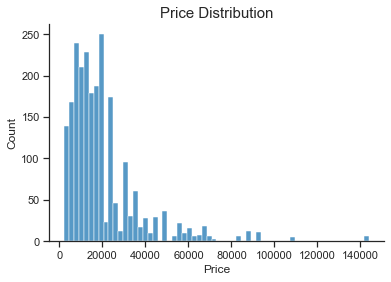

In [164]:
# Target feature distribution

plt.figure()

ax = sns.histplot(data=df_train, x='Price')
ax.set_title("Price Distribution", fontsize=15)
ax.set_xlabel('Price')
ax.set_ylabel('Count')
plt.show()

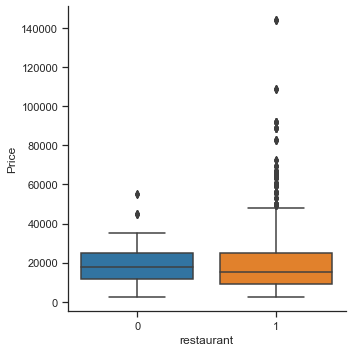

In [165]:
sns.catplot(data=df_train, x="restaurant", y="Price", kind="box")

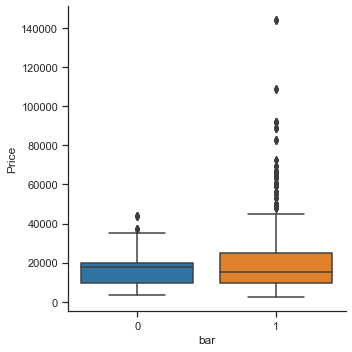

In [166]:
sns.catplot(data=df_train, x="bar", y="Price", kind="box")

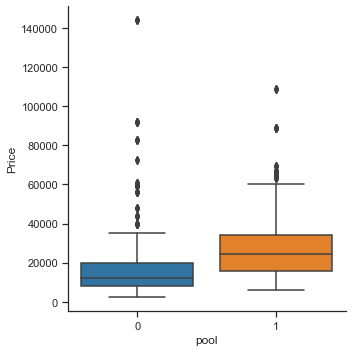

In [167]:
sns.catplot(data=df_train, x="pool", y="Price", kind="box")

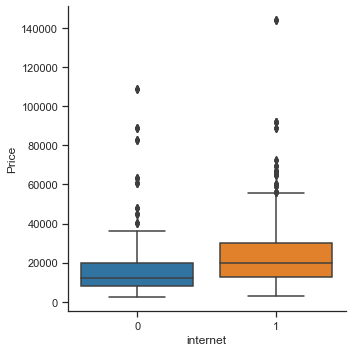

In [168]:
sns.catplot(data=df_train, x="internet", y="Price", kind="box")

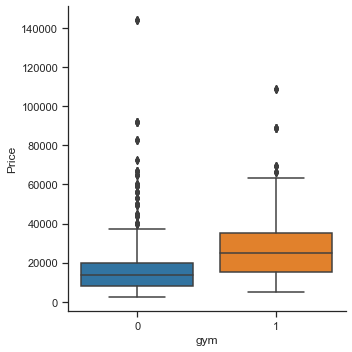

In [169]:
sns.catplot(data=df_train, x="gym", y="Price", kind="box")

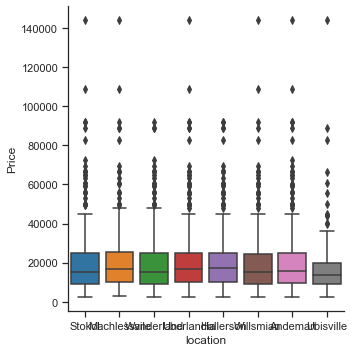

In [170]:
sns.catplot(data=df_train, x="location", y="Price", kind="box")

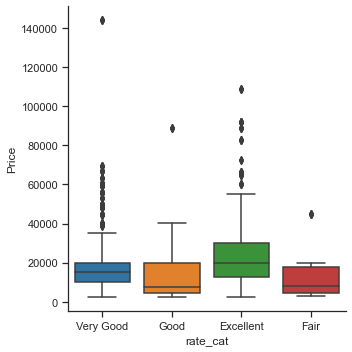

In [171]:
sns.catplot(data=df_train, x="rate_cat", y="Price", kind="box")

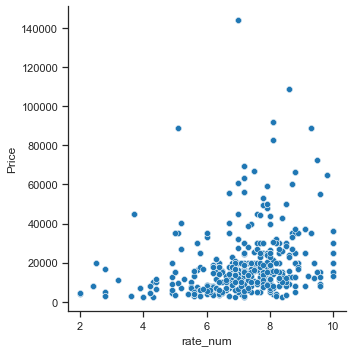

In [172]:
sns.relplot(data=df_train, x="rate_num", y="Price")

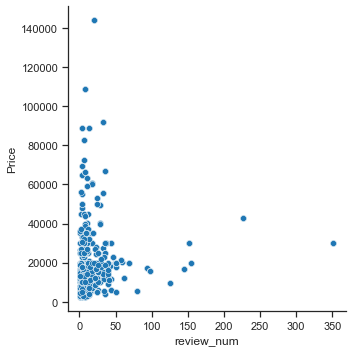

In [173]:
sns.relplot(data=df_train, x="review_num", y="Price")

`Location` sama `review_num` ga ngasih pengaruh signifikan, buang aja

# Modeling

### Train and Test Split

In [174]:
df_train

,facilities,rating,location,Price,restaurant,bar,pool,internet,gym,rate_num,rate_cat,review_num
0,restaurant bar pool,7.8 Very GoodFrom 10 reviews,Stokol,13500,1,1,1,0,0,7.8,Very Good,10
1,internet restaurant gym,5.6 GoodFrom 4 reviews,Machlessvile,13000,1,0,0,1,1,5.6,Good,4
2,restaurant gym pool bar,7.2 Very GoodFrom 38 reviews,Wanderland,19000,1,1,1,0,1,7.2,Very Good,38
3,bar restaurant,7.3 Very GoodFrom 6 reviews,Uberlandia,6000,1,1,0,0,0,7.3,Very Good,6
4,internet restaurant,7.2 Very GoodFrom 30 reviews,Stokol,20000,1,0,0,1,0,7.2,Very Good,30
...,...,...,...,...,...,...,...,...,...,...,...,...
2299,restaurant bar,7.6 Very GoodFrom 3 reviews,Andeman,5000,1,1,0,0,0,7.6,Very Good,3
2300,bar restaurant pool gym,7.8 Very GoodFrom 351 reviews,Andeman,30000,1,1,1,0,1,7.8,Very Good,351
2301,restaurant bar internet,8.1 ExcellentFrom 4 reviews,Uberlandia,30500,1,1,0,1,0,8.1,Excellent,4
2302,bar restaurant pool,6.7 Very GoodFrom 10 reviews,Willsmian,14000,1,1,1,0,0,6.7,Very Good,10


In [175]:
df_test_features

,ID,facilities,rating,location,restaurant,bar,pool,internet,gym,rate_num,rate_cat,review_num
0,0,gym restaurant bar internet pool,8.0 ExcellentFrom 1 reviews,Stokol,1,1,1,1,1,8.0,Excellent,1
1,1,pool restaurant gym internet bar,7.4 Very GoodFrom 22 reviews,Hallerson,1,1,1,1,1,7.4,Very Good,22
2,2,bar pool internet gym,0.0 FairFrom 4 reviews,Hallerson,0,1,1,1,1,0.0,Fair,4
3,3,gym pool bar internet restaurant,6.8 Very GoodFrom 13 reviews,Andeman,1,1,1,1,1,6.8,Very Good,13
4,4,gym restaurant pool bar internet,0.0 FairFrom 9 reviews,Hallerson,1,1,1,1,1,0.0,Fair,9
...,...,...,...,...,...,...,...,...,...,...,...,...
762,762,bar pool restaurant gym,8.1 ExcellentFrom 9 reviews,Andeman,1,1,1,0,1,8.1,Excellent,9
763,763,internet gym pool restaurant bar,8.0 ExcellentFrom 4 reviews,Wanderland,1,1,1,1,1,8.0,Excellent,4
764,764,restaurant gym internet bar pool,7.4 Very GoodFrom 19 reviews,Andeman,1,1,1,1,1,7.4,Very Good,19
765,765,gym internet bar pool restaurant,9.0 ExcellentFrom 17 reviews,Hallerson,1,1,1,1,1,9.0,Excellent,17


In [217]:
features = ['restaurant', 'bar', 'pool', 'internet', 'gym', 'rate_num']
X = df_train[features]
y = df_train['Price']

X_test = df_test_features[features]

In [177]:
print(len(X.columns))
print(len(X_test.columns))

6
6


In [218]:
# train and validation score
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

### Spot Check Algorithm

In [130]:
from IPython.display import display 
import re
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBRegressor

In [132]:
# Spot Check Algorithms

models = [
    ('MLR', LinearRegression()),
    ('R', Ridge(random_state=42)),
    ('L', Lasso(random_state=42)),
    ('CART', DecisionTreeRegressor(criterion='absolute_error', random_state=42)),
    ('RF', RandomForestRegressor(criterion='absolute_error', random_state=42))
]

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=5, random_state=42, shuffle=True)
	cv_results = -1 * cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
	results.append(cv_results)
	names.append(name)

In [133]:
results_df = pd.DataFrame(np.array(results).T)
results_df.columns = names
results_df

,MLR,R,L,CART,RF
0,10207.340075,10206.475715,10206.878202,4619.213873,5313.179855
1,10522.219757,10519.811198,10521.572203,4374.890173,4791.299798
2,9993.318178,9991.698552,9992.639424,4105.468208,5043.426040
3,10376.171425,10375.677817,10375.952738,4997.930435,5841.322391
4,10269.839802,10269.791209,10269.728239,4984.598551,5351.147130


In [134]:
for col in results_df.columns:
    print(f'{col} \t| Mean: {results_df[col].mean()} \t| Std: {results_df[col].std()}')

MLR 	| Mean: 10273.777847351203 	| Std: 197.03739440633564
R 	| Mean: 10272.690897999908 	| Std: 196.86563007019015
L 	| Mean: 10273.354161274681 	| Std: 197.08603999320093
CART 	| Mean: 4616.420247968501 	| Std: 387.4667255303044
RF 	| Mean: 5268.075043076149 	| Std: 392.2147839647916


### Decision Tree Regressor

In [180]:
def getMaxDepth(model):
    depth = np.arange(2, 16, 1)
    mae_score = []
    for i in depth:
        mymodel = model(criterion='absolute_error', max_depth=i, random_state=42)
        mymodel.fit(X_train, y_train)
        y_pred = mymodel.predict(X_val)
        MAE = mae(y_val, y_pred)
        mae_score.append(MAE)
        print(f'Max Depth: {i} \t| mae: {MAE}')

    print('Depth with lowest MAE:', mae_score.index(min(mae_score))+2)

In [181]:
getMaxDepth(model=DecisionTreeRegressor)

Max Depth: 2 	| mae: 8550.079861111111
Max Depth: 3 	| mae: 8246.779513888889
Max Depth: 4 	| mae: 7869.286458333333
Max Depth: 5 	| mae: 7118.482638888889
Max Depth: 6 	| mae: 6855.458333333333
Max Depth: 7 	| mae: 5952.104166666667
Max Depth: 8 	| mae: 5375.631944444444
Max Depth: 9 	| mae: 4731.0234375
Max Depth: 10 	| mae: 4463.963541666667
Max Depth: 11 	| mae: 4016.565972222222
Max Depth: 12 	| mae: 4059.1875
Max Depth: 13 	| mae: 4004.890625
Max Depth: 14 	| mae: 4091.5225694444443
Max Depth: 15 	| mae: 4100.550347222223
Depth with lowest MAE: 13


In [203]:
model = DecisionTreeRegressor(criterion='absolute_error', max_depth=13, random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=13, random_state=42)

In [206]:
dtr_pred = model.predict(X_val)
mae(dtr_pred, y_val)

4004.890625

### Random Forest Regressor

In [182]:
getMaxDepth(model=RandomForestRegressor)

Max Depth: 2 	| mae: 8472.93454861111
Max Depth: 3 	| mae: 8115.915885416666
Max Depth: 4 	| mae: 7660.797413194444
Max Depth: 5 	| mae: 7091.376293402778
Max Depth: 6 	| mae: 6530.101796874999
Max Depth: 7 	| mae: 5971.680815972221
Max Depth: 8 	| mae: 5478.484913194445
Max Depth: 9 	| mae: 5033.787170138889
Max Depth: 10 	| mae: 4706.874140625
Max Depth: 11 	| mae: 4549.798819444444
Max Depth: 12 	| mae: 4393.8000694444445
Max Depth: 13 	| mae: 4357.043506944445
Max Depth: 14 	| mae: 4394.27046875
Max Depth: 15 	| mae: 4375.310277777778
Depth with lowest MAE: 13


In [219]:
model = RandomForestRegressor(n_estimators = 50, random_state = 42, max_depth = 13, criterion='absolute_error')
model.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=13, n_estimators=50,
                      random_state=42)

In [220]:
rf_pred = model.predict(X_val)
mae(rf_pred, y_val)

4354.892552083333

### XGB Regressor

In [224]:
model = XGBRegressor(n_estimators=300, early_stopping_rounds=5, 
eval_metric=mae, learning_rate=0.02, max_depth=15, random_state=42)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:24753.94341	validation_0-mean_absolute_error:18878.06836
[1]	validation_0-rmse:24370.85264	validation_0-mean_absolute_error:18516.57617
[2]	validation_0-rmse:23996.62955	validation_0-mean_absolute_error:18161.81250
[3]	validation_0-rmse:23631.56414	validation_0-mean_absolute_error:17815.08008
[4]	validation_0-rmse:23274.72599	validation_0-mean_absolute_error:17475.98633
[5]	validation_0-rmse:22925.48225	validation_0-mean_absolute_error:17144.24219
[6]	validation_0-rmse:22584.41933	validation_0-mean_absolute_error:16819.56836
[7]	validation_0-rmse:22249.94645	validation_0-mean_absolute_error:16505.84180
[8]	validation_0-rmse:21922.77026	validation_0-mean_absolute_error:16198.93066
[9]	validation_0-rmse:21600.71322	validation_0-mean_absolute_error:15903.81055
[10]	validation_0-rmse:21289.32706	validation_0-mean_absolute_error:15611.10742
[11]	validation_0-rmse:20982.23905	validation_0-mean_absolute_error:15333.09180
[12]	validation_0-rmse:20683.37532	validation_0-me

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x000001CAD75F63A0>,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=15, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, ...)

In [225]:
xgb_pred = model.predict(X_val)
mae(xgb_pred, y_val)

4547.190928141276

### CatBoost Regressor

In [227]:
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

In [228]:
model = CatBoostRegressor(random_state=42)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

Learning rate set to 0.055487
0:	learn: 17514.5393270	test: 15984.8888804	best: 15984.8888804 (0)	total: 147ms	remaining: 2m 26s
1:	learn: 17273.9808222	test: 15736.5510548	best: 15736.5510548 (1)	total: 147ms	remaining: 1m 13s
2:	learn: 17088.0459325	test: 15535.1099488	best: 15535.1099488 (2)	total: 148ms	remaining: 49.2s
3:	learn: 16884.1405367	test: 15322.3980225	best: 15322.3980225 (3)	total: 149ms	remaining: 37.1s
4:	learn: 16709.7588467	test: 15138.4756138	best: 15138.4756138 (4)	total: 150ms	remaining: 29.8s
5:	learn: 16561.6044853	test: 14987.7741441	best: 14987.7741441 (5)	total: 150ms	remaining: 24.9s
6:	learn: 16422.0417427	test: 14834.8284734	best: 14834.8284734 (6)	total: 151ms	remaining: 21.4s
7:	learn: 16291.7676876	test: 14699.8919311	best: 14699.8919311 (7)	total: 152ms	remaining: 18.8s
8:	learn: 16138.2085408	test: 14544.8925987	best: 14544.8925987 (8)	total: 153ms	remaining: 16.8s
9:	learn: 16051.1148800	test: 14451.6002615	best: 14451.6002615 (9)	total: 154ms	remai

In [229]:
cb_pred = model.predict(X_val)
mae(cb_pred, y_val)

5503.703127200144

In [235]:
Acc = pd.DataFrame(index=None, columns=['model','MAE','Accuracy on Traing set','Accuracy on Testing set'])

In [236]:
  regressors = [['DecisionTreeRegressor',DecisionTreeRegressor()],
              ['XGBRegressor', XGBRegressor()],
              ['RandomForestRegressor', RandomForestRegressor()],
              ['MLPRegressor',MLPRegressor()],
              ['AdaBoostRegressor',AdaBoostRegressor()],
              ['ExtraTreesRegressor',ExtraTreesRegressor()]]

for mod in regressors:
    name = mod[0]
    model = mod[1]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    
    MAE = mae(y_val, y_pred)
    ATrS =  model.score(X_train,y_train)
    ATeS = model.score(X_val,y_val)
    
    Acc = Acc.append(pd.Series({'model':name, 'MAE': MAE,'Accuracy on Traing set':ATrS,'Accuracy on Testing set':ATeS}),ignore_index=True )

In [237]:
Acc

,model,MAE,Accuracy on Traing set,Accuracy on Testing set
0,DecisionTreeRegressor,4497.061146,0.646656,0.586852
1,XGBRegressor,4588.080782,0.646502,0.587274
2,RandomForestRegressor,4625.645904,0.645545,0.585377
3,MLPRegressor,15394.142713,-0.874289,-0.871335
4,AdaBoostRegressor,10584.4403,0.141328,0.030429
5,ExtraTreesRegressor,4485.793785,0.646656,0.587043


### Extra Tree Regressor

In [241]:
model = ExtraTreesRegressor(random_state=42)

model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [242]:
et_pred = model.predict(X_val)
mae(et_pred, y_val)

4491.542048787372

# Submission

In [221]:
submission_format = pd.read_csv('data/submission_format.csv')

In [199]:
submission_format

,ID,Price
0,0,22000
1,1,22000
2,2,22000
3,3,22000
4,4,22000
...,...,...
762,762,22000
763,763,22000
764,764,22000
765,765,22000


In [243]:
# prediction for test dataset
preds = model.predict(X_test)

submission = pd.DataFrame({
    'ID': submission_format.ID,
    'Price': preds
})

submission.head()

,ID,Price
0,0,19140.0
1,1,23823.3
2,2,7510.0
3,3,9750.0
4,4,14850.0


In [244]:
# export submission to csv

submission.to_csv('submission.csv', index=False)
print('Successfully saved!')

Successfully saved!
